In [119]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

import streamlit as st

import os

import warnings
warnings.filterwarnings('ignore')

In [120]:
def normalize_data(dataframe):
  
    """
    Standardize the data and perform PCA for dimensionality reduction.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame to standardize and reduce.

    Returns:
    tuple: Scaler, PCA model, and the transformed DataFrame.
    """    
    #Normalize the data using StandardScaler
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(dataframe)
    
    return scaled_df, scaler

In [121]:
def load_and_clean_data(filepath):
    """
    Load the CSV data and clean it by dropping unnecessary columns and renaming columns for clarity.
    
    Args:
    filepath (str): The path to the CSV file.

    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """
    
    #Make area name the index
    df = pd.read_csv(filepath, index_col='Area')  
    df = df.drop('City of London', axis=0)
      
    df = df.rename(columns={
        'Poverty rate': 'PovertyRate',
        'Unemployment rate': 'UnemploymentRate',
        'Percentage of pupils who achieved grade 9-4': 'PupilsGrade9To4',
        'crime rates': 'CrimeRates',
        'average property price 2024 Feb': 'AvgPropertyPriceFeb2024',
        'Fair pay (London Living Wage) ': 'LondonLivingWage',
        'Healthy Life Expentency': 'HealthyLifeExpectancy',
        'Green Space': 'GreenSpace',
        'Air Quality': 'AirQuality',
        'Carbon Emission': 'CarbonEmission',
        'Energy Efficiency': 'EnergyEfficiency',
        'Waste reduction': 'WasteReduction',
        'Being Ready for School': 'SchoolReadiness',
        'Good Qualification 16+': 'Qualification16Plus'
    })
    
    df = df.drop(columns=['AirQuality'])
    
    return df

In [122]:
def generate_user_preference(dataframe):
    
    """
    Generate random user preferences based on the range of numeric columns in the DataFrame for a single user.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    np.ndarray: An array of random user preferences.
    """
    
    numeric_columns = dataframe.select_dtypes(include=[np.number]).columns.tolist()
    min_values = dataframe[numeric_columns].min()
    max_values = dataframe[numeric_columns].max()
    user_preference = np.random.rand(1, len(numeric_columns)) * (max_values - min_values).values + min_values.values
    
    print(f"User Preferences: {np.round(user_preference, 2)}")
    
    return user_preference

In [123]:
def impute_missing_data(dataframe):
  
    """
    Impute missing data in the DataFrame using Mean.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame with missing values.

    Returns:
    pd.DataFrame: The DataFrame with imputed values.
    """
    #Impute missing values with Mean
    imputed_df = dataframe.fillna(dataframe.mean())
    
        
    return imputed_df

In [124]:
def visualize_data(dataframe):
  
    """
    Visualize data distributions and correlations using seaborn and matplotlib.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame to visualize.
    """
    #Visualize data distributions
    plt.figure(figsize=(16, 6))
    sns.pairplot(dataframe)

    
    plt.figure(figsize=(16, 6))
    
    heatmap = sns.heatmap(dataframe.corr(), annot=True)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
    
    plt.show()

In [125]:
def reduce_dimensionality(dataframe):
  
    """
    Standardize the data and perform PCA for dimensionality reduction.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame to standardize and reduce.

    Returns:
    tuple: Scaler, PCA model, and the transformed DataFrame.
    """
    
    pca = PCA(n_components=2)
    pca_df = pca.fit_transform(scaled_df)
    
    return pca,pca_df

In [126]:
def perform_clustering(data, num_clusters=5):
  
    """
    Perform K-Means clustering on the data.
    
    Args:
    data (np.ndarray): The input data for clustering.
    num_clusters (int): The number of clusters for K-Means.

    Returns:
    tuple: KMeans model and cluster labels.
    """
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    
    clusters = kmeans.fit_predict(data)
    
    return kmeans, clusters

In [127]:
def ranked_borough(dataframe, clusters, user_preference, scaler, pca, kmeans):
    """
    Recommend boroughs based on a single user's preferences and clustered data.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame.
    clusters (np.ndarray): Cluster labels for the data.
    user_preference (np.ndarray): Single user preferences to match with clusters.
    scaler (StandardScaler): The scaler used for data standardization.
    pca (PCA): The PCA model used for dimensionality reduction.
    kmeans (KMeans): The KMeans model used for clustering.

    Returns:
    list: Recommended boroughs for the nearest user cluster.
    """
    
    user_preference_scaled = scaler.transform(user_preference)
    user_pca_preference = pca.transform(user_preference_scaled)
    centroids = kmeans.cluster_centers_
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(centroids)
    distances, nearest_cluster_indices = nn.kneighbors(user_pca_preference)
    nearest_cluster = nearest_cluster_indices.flatten()[0]
    print("Nearest Cluster for User Preference:", nearest_cluster)
    
    dataframe['Cluster'] = clusters
    nearest_cluster_boroughs = dataframe[dataframe['Cluster'] == nearest_cluster]
    
    # Calculate distances between user preferences and boroughs in the nearest cluster
    cluster_data = nearest_cluster_boroughs.drop(['Area', 'Cluster'], axis=1)
    cluster_data_scaled = scaler.transform(cluster_data)
    cluster_data_pca = pca.transform(cluster_data_scaled)
    distances = cdist(user_pca_preference, cluster_data_pca, 'euclidean').flatten()
    
    nearest_cluster_boroughs['Distance'] = distances
    ranked_boroughs = nearest_cluster_boroughs.sort_values(by='Distance')
    ranked_boroughs = ranked_boroughs[['Area', 'Distance']]
    
    print("Ranked Boroughs based on User Preference:")
    print(ranked_boroughs)
    return ranked_boroughs

In [128]:
folder_dir = os.path.abspath(os.getcwd())
file_path = os.path.join(folder_dir, "data\\raw_data\\london_borough.csv")

In [129]:
df = load_and_clean_data(file_path)
imputed_df = impute_missing_data(df)
scaled_df, scaler = normalize_data(imputed_df)
scaled_df = pd.DataFrame(scaled_df, columns=imputed_df.columns)
scaled_df['Area'] = imputed_df.index
scaled_df = scaled_df.set_index('Area')

In [130]:
# Main execution
df = load_and_clean_data(file_path)
user_preference = generate_user_preference(df)
imputed_df = impute_missing_data(df)
scaled_df, scaler = normalize_data(imputed_df)
pca, pca_df = reduce_dimensionality(scaled_df)
kmeans, clusters = perform_clustering(pca_df)

User Preferences: [[3.5780000e+01 4.0100000e+00 6.4620000e+01 9.8210000e+01 7.3629692e+05
  8.1700000e+01 6.3650000e+01 1.2610000e+01 7.7000000e-01 2.9000000e-01
  5.2120000e+01 7.0430000e+01 2.2230000e+01 2.2420000e+01 1.8200000e+00]]


In [131]:
pca_df = pd.DataFrame(pca_df, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

pca_df['Area'] = imputed_df.index
pca_df

,PC1,PC2,Cluster,Area
0,-2.204713,1.063542,1,Barking and Dagenham
1,-0.667486,-1.393189,3,Barnet
2,1.170740,-1.958793,2,Bexley
3,-0.874604,-0.111295,3,Brent
4,1.353359,-3.175493,2,Bromley
5,-0.449143,1.524301,0,Camden
6,5.692642,5.222186,4,City of London
7,-0.599704,-0.804211,3,Croydon
8,-0.904924,-1.292548,3,Ealing
9,-0.787746,-1.125545,3,Enfield


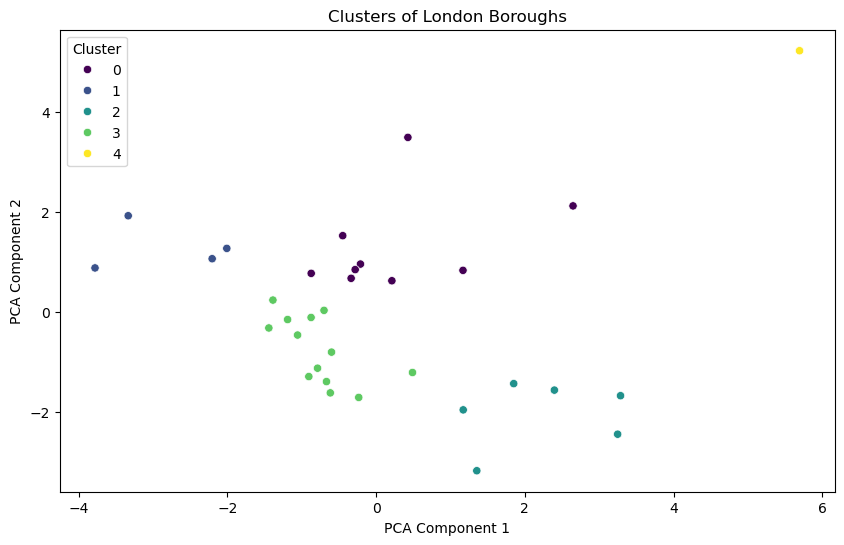

Nearest Cluster for User Preference: 0
Ranked Boroughs based on User Preference:
                                          Area  Distance
Area                                                    
Westminster                        Westminster  1.933395
Kensington and Chelsea  Kensington and Chelsea  2.738887
Camden                                  Camden  3.986921
Hammersmith and Fulham  Hammersmith and Fulham  3.987685
Islington                            Islington  4.338876
Waltham Forest                  Waltham Forest  4.457615
Wandsworth                          Wandsworth  4.469835
Haringey                              Haringey  4.648820
Lewisham                              Lewisham  4.846841


In [132]:
# Visualization of clusters
df['Cluster'] = clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette="viridis", legend="full")
plt.title('Clusters of London Boroughs')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Ensure 'Area' column is present in imputed_df
imputed_df['Area'] = df.index

ranked_boroughs = ranked_borough(imputed_df, clusters, user_preference, scaler, pca, kmeans)


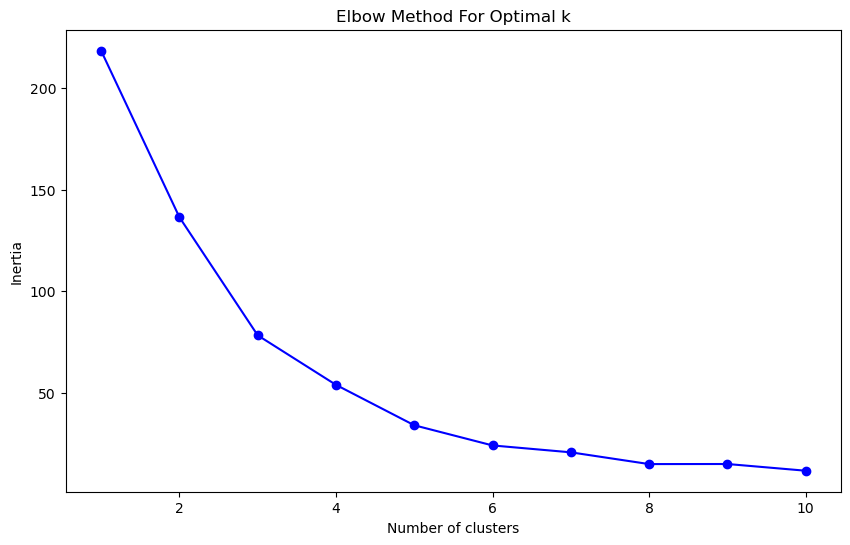

In [133]:
# Elbow Method to find the optimal number of clusters
def find_optimal_clusters(data, max_k=10):
  """
  Use the Elbow Method to find the optimal number of clusters for KMeans.

  Args:
  data (np.ndarray): The input data for clustering.
  max_k (int): The maximum number of clusters to test.

  Returns:
  None
  """
  inertia = []
  K = range(1, max_k + 1)
  
  for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)
  
  plt.figure(figsize=(10, 6))
  plt.plot(K, inertia, 'bo-')
  plt.xlabel('Number of clusters')
  plt.ylabel('Inertia')
  plt.title('Elbow Method For Optimal k')
  plt.show()

# Use the function to find the optimal number of clusters
find_optimal_clusters(pca_df[['PC1', 'PC2']])

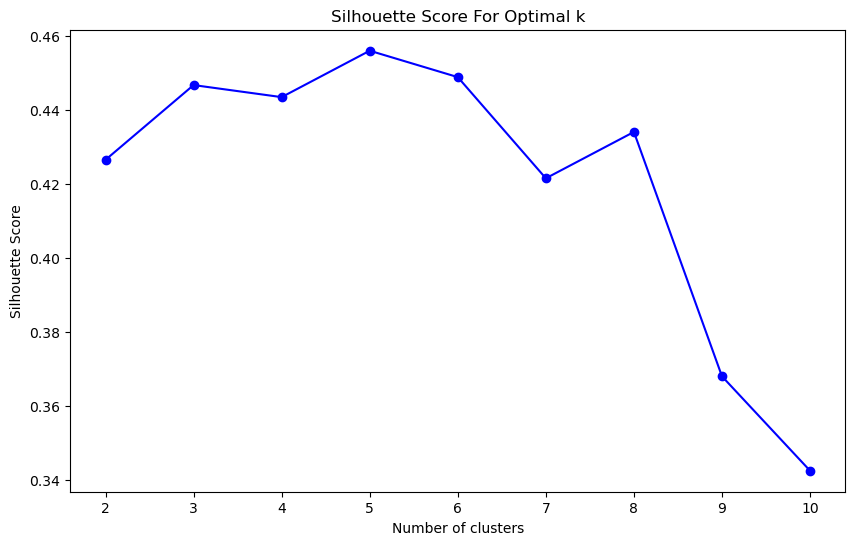

In [134]:
from sklearn.metrics import silhouette_score

def find_optimal_clusters_silhouette(data, max_k=10):
  """
  Use the Silhouette Score to find the optimal number of clusters for KMeans.

  Args:
  data (np.ndarray): The input data for clustering.
  max_k (int): The maximum number of clusters to test.

  Returns:
  None
  """
  silhouette_scores = []
  K = range(2, max_k + 1)
  
  for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    score = silhouette_score(data, kmeans.labels_)
    silhouette_scores.append(score)
  
  plt.figure(figsize=(10, 6))
  plt.plot(K, silhouette_scores, 'bo-')
  plt.xlabel('Number of clusters')
  plt.ylabel('Silhouette Score')
  plt.title('Silhouette Score For Optimal k')
  plt.show()

# Use the function to find the optimal number of clusters
find_optimal_clusters_silhouette(pca_df[['PC1', 'PC2']])

In [135]:
# Streamlit UI
st.title("London Borough Recommender")

st.sidebar.header("User Preferences")

user_preferences = {}
for col in df.columns:
    if col != 'Area':
        user_preferences[col] = st.sidebar.number_input(f"{col}:", value=float(df[col].mean()))

if st.sidebar.button("Submit"):
    user_preference = np.array([[user_preferences[col] for col in user_preferences]])
    ranked_boroughs = ranked_borough(imputed_df, clusters, user_preference, scaler, pca, kmeans)
    st.write("Recommended Boroughs:", ranked_boroughs)
else:
    st.write("Please enter your preferences and click Submit.")